https://github.com/vslobody/MUSIC/blob/master/music.py
https://github.com/dengjunquan/DoA-Estimation-MUSIC-ESPRIT

In [115]:
import numpy as np
from scipy.constants import speed_of_light
import matplotlib.pyplot as plt

In [116]:
INCIDENT_ANGLE = -50  # incident signal angle in degrees
ANTENNA_DISTANCE = 6e-2  # distance between antennas in m
FREQUENCY_DEVIATION = 250e3
NUM_ANTENNAS = 2
BLUETOOTH_FREQUENCY = 2450e6  # Center frequency of Bluetooth channel in Hz
CTE_FREQUENCY = BLUETOOTH_FREQUENCY + FREQUENCY_DEVIATION
CTE_WAVELENGTH = speed_of_light / CTE_FREQUENCY  # Bluetooth wavelength in m
CTE_TIME = 160e-6 # Constant Tone Extension time  
CTE_SAMPLES = 50
NUM_SOURCES = 1
NUM_ANGLES_TO_SEARCH = 360
MAX_SEARCH_ANGLE = 90
SNR = 10

In [117]:
def response_vec(num_antennas: int, incident_angle: float) -> np.ndarray:
    """Expected antenna array response column vector of IQ values, not accounting for noise"""
    antennas = np.arange(0, num_antennas) * ANTENNA_DISTANCE
    steering = np.exp(
        2j * np.pi * antennas * np.sin(np.deg2rad(incident_angle)) / CTE_WAVELENGTH
    ).reshape((-1, 1))
    return steering


antenna_response = response_vec(NUM_ANTENNAS, INCIDENT_ANGLE)

In [118]:
sample_times = np.linspace(0, CTE_TIME, CTE_SAMPLES)
sample_covariance = np.zeros(shape=(NUM_ANTENNAS, NUM_ANTENNAS), dtype=complex)
for t in sample_times:
    iq_sample_at_t = antenna_response + np.sqrt(0.5/SNR)*np.random.randn(NUM_ANTENNAS)
    sample_covariance += iq_sample_at_t @ iq_sample_at_t.conjugate().T
sample_covariance /= CTE_SAMPLES

_, cov_eigvecs = np.linalg.eig(sample_covariance)
non_noise_cov_eigvecs = cov_eigvecs[:,NUM_SOURCES:NUM_ANTENNAS]

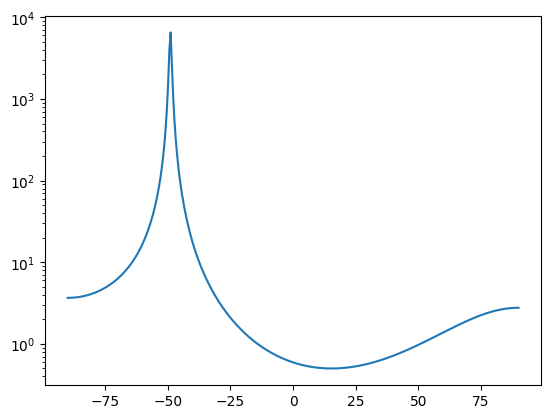

In [119]:
signal_power = np.ndarray(shape=(NUM_ANGLES_TO_SEARCH,), dtype=complex)
search_angles = np.linspace(-MAX_SEARCH_ANGLE, MAX_SEARCH_ANGLE, NUM_ANGLES_TO_SEARCH)

for idx, angle in enumerate(search_angles):
    steering_at_test_angle = response_vec(NUM_ANTENNAS, angle)
    signal_power[idx] = (
        1
        / (
            steering_at_test_angle.conjugate().T
            @ non_noise_cov_eigvecs
            @ non_noise_cov_eigvecs.conjugate().T
            @ steering_at_test_angle
        )
    ).item()


signal_power
fig, ax = plt.subplots()
ax.semilogy(search_angles, signal_power)
